In [1]:
%matplotlib inline

import numpy as np
from scipy import signal, ndimage, interpolate

import matplotlib.pyplot as plt
import seaborn as sns
font = {'family' : 'sans-serif',
        'size'   : 20}

plt.rc('font', **font)

from pathlib import Path
import os,sys
import h5py
import sys 

from circus.shared.parser import CircusParser
from circus.shared.files import load_data
import time

sys.path.append('../PreProcessing/')  
from get_neuralynx import *

/Users/alexgonzalez/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [15]:
animal = 'Li'
task = 'OF'
date = '062718'

filename = animal+'_'+task+'_'+date+'_Results'
datPath=Path('/Users/alexgonzalez/Google Drive/PostDoc/Data/',task,animal,filename)
savePath=Path(datPath,'plots/spatial_tuning/')
savePath.mkdir(parents=True, exist_ok=True)
cwd = datPath.cwd()

In [186]:
# Read t,x,y
with h5py.File((datPath / 'VT1.h5'), 'r') as f:
    t = f.get('t').value
    x = f.get('x').value
    y = f.get('y').value


In [210]:
def smooth_hist2d(img,w,sigma=1.5):
    trunc = (((w - 1)/2)-0.5)/sigma
    return ndimage.filters.gaussian_filter(img,sigma,mode='constant',truncate=trunc)
    

### Occupancy Map

In [206]:
ylims = [40, 180]
xlims = [65, 250]
#ylims = [np.min(y),np.max(y)]
step=5 # cm

yedges=np.arange(ylims[0]-step,ylims[1]+step,step)
xedges=np.arange(xlims[0]-step,xlims[1]+step,step)

position_2d, pos_xedges, pos_yedges = np.histogram2d(x,y, bins=[xedges, yedges])
# convert position occupancy to time. 
T = np.max(t)-np.min(t)
print('Total Time = ', T)
nBins = position_2d.size
print('Total number of bins = ', nBins)
nOccBin = position_2d.sum()
print('Total number of occupancy ticks = ', nOccBin)
bin2time = T/nOccBin;
print('Bin to Time conversion factor [s] = ', bin2time)
Time_2d = position_2d*bin2time

Total Time =  645.3941599999998
Total number of bins =  1102
Total number of occupancy ticks =  38317.0
Bin to Time conversion factor [s] =  0.016843546206644567


#### check for appropriate smoothing parameters. 

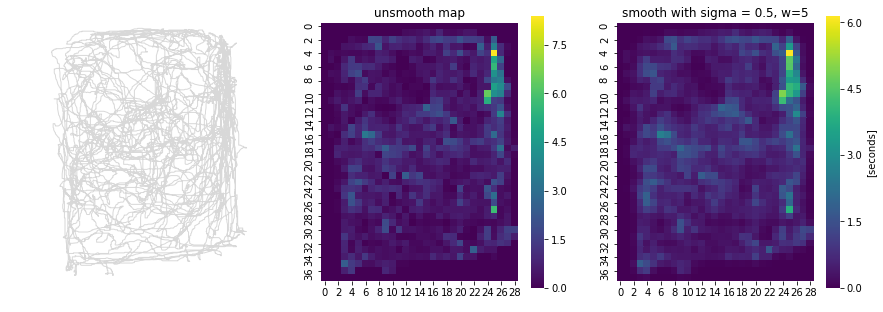

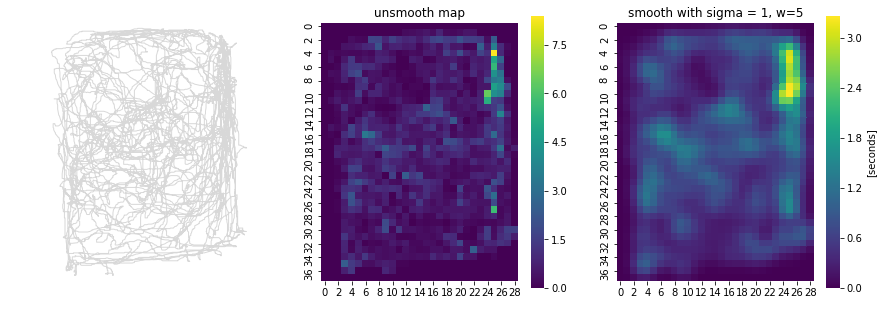

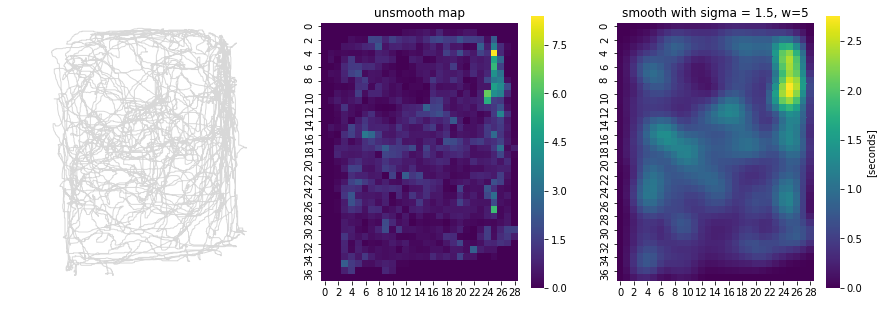

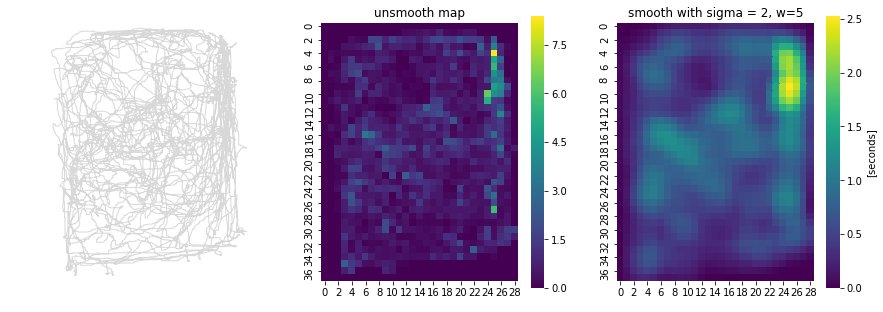

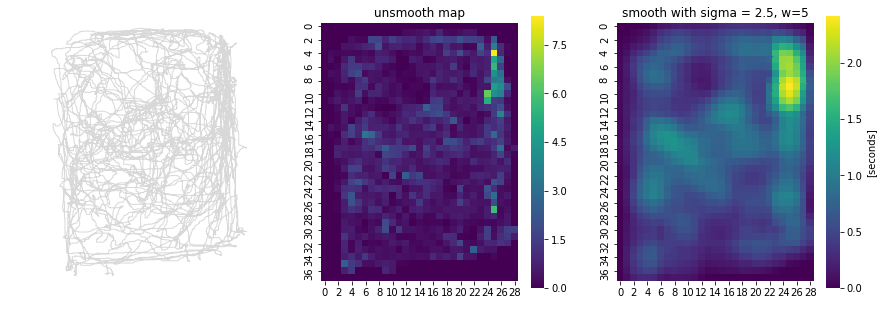

In [219]:
sigmas = [0.5, 1, 1.5, 2, 2.5]
w = 5 # number of bins    
for s in sigmas:
    f,(a1,a2,a3)=plt.subplots(1,3, figsize=(15,5))
    
    #rotate x, y to match histograms
    x2=y
    y2=-x
    a1.plot(x2,y2,linewidth=1,color='grey',alpha=0.3)   
    a1.set_aspect('equal', adjustable='box')
    a1.set_axis_off()
    
    sns.heatmap(Time_2d,cmap='viridis',square=T,ax=a2)
    a2.set_title('unsmooth map')
    trunc = (((w - 1)/2)-0.5)/s
    psmooth = smooth_hist2d(Time_2d,w,s)
    sns.heatmap(psmooth,cmap='viridis',ax=a3,square=T, cbar_kws={'label': '[seconds]'})
    a3.set_title('smooth with sigma = {}, w={}'.format(s,w))

#### with w=5, sigma=1-1.5,  seems to yield the best results. 

## Get Neurons for the session

In [17]:
os.chdir(str(datPath))
cl = {}
SpikeTrains = {}
time=np.arange(t[0],t[len(t)-1]+1,step=1/32000)
for tt in np.arange(1,17):
    try:
        params    = CircusParser(str(datPath)+'/tt_'+str(tt)+'.npy')
        results = load_data(params, 'results') # To load the templates
        nTemps = len(results['spiketimes'])
        #time = np.arange(97)/32
        for ti in np.arange(nTemps):
            cl['TT{}_Temp{}'.format(tt,ti)]=np.copy(results['spiketimes']['temp_{}'.format(ti)])
            SpikeTrains['TT{}_Temp{}'.format(tt,ti)]=nept.SpikeTrain(time[results['spiketimes']['temp_{}'.format(ti)]]) 
    except:
        print('Could not load template for tetrode {}'.format(tt))
        print ("error", sys.exc_info()[0],sys.exc_info()[1],sys.exc_info()[2].tb_lineno)


In [ ]:
# Define the X and Y boundaries from the unfiltered position, with 3 cm bins
if not task=='OF':
    y2=-x+225
    x2=y-110
    p = nept.Position(np.array([x2,y2]).T,t)
    xlims = [-70,60]
    ylims = [0,150]

    step=2
    sigma=2.5
    occupied_thresh=0.8
    
    yedges=np.arange(ylims[0]-step,ylims[1]+step,step)
    xedges=np.arange(xlims[0]-step,xlims[1]+step,step)
    alpha1=0.2
    alpha2=0.1

    x2=p.data.T[0]
    y2=p.data.T[1]
    
    badIDs = np.logical_and(x2<-50, y2<60)
    r=np.append(0,np.sqrt(x**2+y**2))
    rd=np.diff(r)
    badIDs = np.logical_or(badIDs, y2>140)
    badIDs = np.logical_or(badIDs, abs(rd)>10)

    x2=signal.medfilt(x2,13)
    #x2=x2[~badIDs]
    x2[badIDs]=np.nan
    #x2=signal.medfilt(x2,31)

    y2=signal.medfilt(y2,13)
    x2[badIDs]=np.nan
    #y2=y2[~badIDs]
    #y2=signal.medfilt(y2,31)

elif task=='OF':
    y2=-x+245
    x2=y-110
    p = nept.Position(np.array([x2,y2]).T,t)

    xlims = [-75,70]
    ylims = [0,175]
    alpha1=0.3
    alpha2=0.2
    step=3
    yedges=np.arange(ylims[0]-step,ylims[1]+step,step)
    xedges=np.arange(xlims[0]-step,xlims[1]+step,step)
    occupied_thresh=1000
    sigma=5
    x2=p.data.T[0]
    y2=p.data.T[1]
    
f_xy=interpolate.interp1d(p.time,p.data.T, kind="nearest",fill_value="extrapolate")
for key in SpikeTrains.keys():
    if task=='OF':
         f,(a1,a2)=plt.subplots(1,2, figsize=(10,5))
    else:
        f,(a1,a2)=plt.subplots(1,2, figsize=(10,5))

    # panel a
    xy=f_xy(SpikeTrains[key].time)
    a1.plot(x2,y2,linewidth=0.5,color='grey',alpha=alpha1)
    a1.scatter(xy[0],xy[1],15, color='red',alpha=alpha2)
    a1.set_axis_off()
    a1.set_xlim(xlims[0]-step,xlims[1]+step)
    a1.set_ylim(ylims[0]-step,ylims[1]+step)

    # panel b
    tuning_curves = nept.tuning_curves.tuning_curve_2d(p, [SpikeTrains[key]], xedges, yedges,
                                         occupied_thresh=occupied_thresh, gaussian_std=sigma)

    vmax=np.percentile(tuning_curves[0].flatten(),[97.5])
    h2=sns.heatmap(tuning_curves[0],cmap='viridis',xticklabels=False,yticklabels=False,ax=a2,
                       cbar=False,robust=False,vmax=vmax)
    h2.invert_yaxis()
    a2.text(0, len(yedges)+2, 'max FR=%0.2f [sp/s]'%(vmax))

#     if task=='OF':
#         # panel c
#         h3=sns.heatmap(ndimage.correlate(tuning_curves[0],tuning_curves[0]),cmap='magma',robust=True,ax=a3,xticklabels=False,yticklabels=False,cbar=False)
#         h3.invert_yaxis()

    f.savefig(str(savePath / '{}_SpatialTuning.png'.format(key)),bbox_inches='tight',dpi = 300)


Text(0,39,'max FR=3.60 [sp/s]')

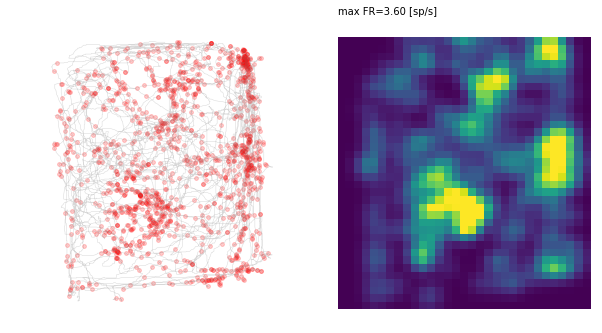

In [112]:
### 
key = 'TT2_Temp3'

if not task=='OF':
    f,(a1,a2)=plt.subplots(1,2, figsize=(10,5))
    
    y2=-x+225
    x2=y-110
    p = nept.Position(np.array([x2,y2]).T,t)

    xlims = [-70,60]
    ylims = [0,150]

    step=2
    sigma=2.5
    occupied_thresh=0.8
    
    yedges=np.arange(ylims[0]-step,ylims[1]+step,step)
    xedges=np.arange(xlims[0]-step,xlims[1]+step,step)
    alpha1=0.2
    alpha2=0.1

    x2=p.data.T[0]
    y2=p.data.T[1]
    
    badIDs = np.logical_and(x2<-50, y2<60)
    r=np.append(0,np.sqrt(x**2+y**2))
    rd=np.diff(r)
    badIDs = np.logical_or(badIDs, y2>140)
    badIDs = np.logical_or(badIDs, abs(rd)>10)

    x2=signal.medfilt(x2,13)
    #x2=x2[~badIDs]
    x2[badIDs]=np.nan
    #x2=signal.medfilt(x2,31)

    y2=signal.medfilt(y2,13)
    x2[badIDs]=np.nan
    #y2=y2[~badIDs]
    #y2=signal.medfilt(y2,31)

elif task=='OF':
    #f,(a1,a2,a3)=plt.subplots(1,3, figsize=(13,5))
    f,(a1,a2)=plt.subplots(1,2, figsize=(10,5))
    y2=-x+245
    x2=y-110
    p = nept.Position(np.array([x2,y2]).T,t)

    xlims = [-75,75]
    ylims = [0,175]
    alpha1=0.3
    alpha2=0.2
    step=5 # cm
    yedges=np.arange(ylims[0]-step,ylims[1]+step,step)
    xedges=np.arange(xlims[0]-step,xlims[1]+step,step)
    alpha = 0.2
    occupied_thresh=0.5
    sigma=step
    x2=p.data.T[0]
    y2=p.data.T[1]

f_xy=interpolate.interp1d(p.time,p.data.T, kind="nearest",fill_value="extrapolate")
xy=f_xy(SpikeTrains[key].time)

# panel a
a1.plot(x2,y2,linewidth=0.5,color='grey',alpha=alpha1)
a1.scatter(xy[0],xy[1],15, color='red',alpha=alpha2)
a1.set_axis_off()
a1.set_xlim(xlims[0]-step,xlims[1]+step)
a1.set_ylim(ylims[0]-step,ylims[1]+step)

# panel b
#TT2_Temp3, TT8_Temp7, TT10_Temp0, TT10_Temp3, TT10_Temp12,TT10_Temp13
tuning_curves = nept.tuning_curves.tuning_curve_2d(p, [SpikeTrains[key]], xedges, yedges,
                                     occupied_thresh=occupied_thresh, gaussian_std=sigma)

vmax=np.percentile(tuning_curves[0].flatten(),[97.5])
h2=sns.heatmap(tuning_curves[0],cmap='viridis',xticklabels=False,yticklabels=False,ax=a2,
                   cbar=False,robust=False,vmax=vmax)
h2.invert_yaxis()
a2.text(0, len(yedges)+2, 'max FR=%0.2f [sp/s]'%(vmax))

# if task=='OF':
#     # panel c
#     h3=sns.heatmap(ndimage.correlate(tuning_curves[0],tuning_curves[0]),cmap='magma',robust=True,ax=a3,xticklabels=False,yticklabels=False,cbar=False)
#     h3.invert_yaxis()


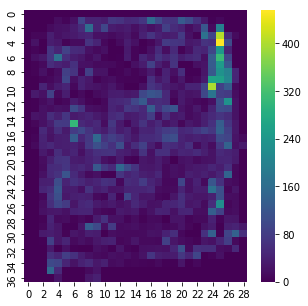

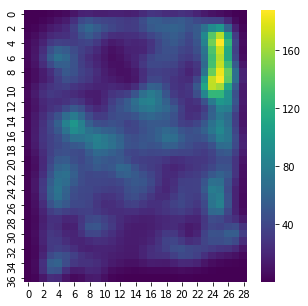

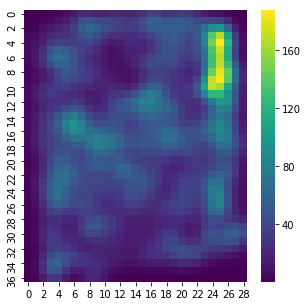

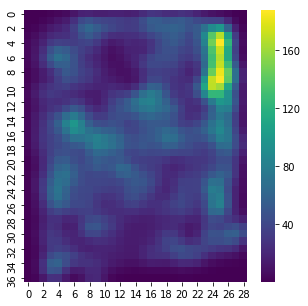

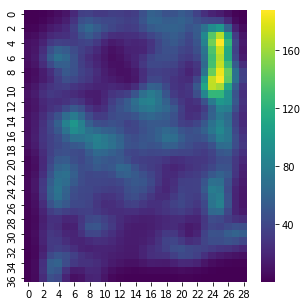

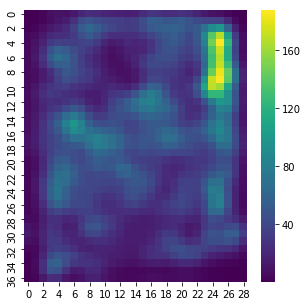

In [124]:
xlims = [np.min(x),np.max(x)]
ylims = [np.min(y),np.max(y)]
step=5 # cm

yedges=np.arange(ylims[0]-step,ylims[1]+step,step)
xedges=np.arange(xlims[0]-step,xlims[1]+step,step)

position_2d, pos_xedges, pos_yedges = np.histogram2d(x,y, bins=[xedges, yedges])

In [178]:
tuning_curves[0]

array([[5.13724067e-04, 6.69683398e-03, 3.89034209e-02, ...,
        8.09073539e-02, 3.29246070e-02, 1.31479339e-02],
       [6.21019148e-03, 4.03970782e-02, 1.85519145e-01, ...,
        3.73971715e-01, 1.86040270e-01, 1.21056345e-01],
       [5.82593967e-02, 1.57993041e-01, 4.91890943e-01, ...,
        8.03733540e-01, 5.23101963e-01, 4.85652766e-01],
       ...,
       [4.66152342e-02, 2.22986525e-01, 5.36211061e-01, ...,
        2.59978049e-02, 1.55690338e-03, 0.00000000e+00],
       [2.12825450e-02, 1.05616789e-01, 2.61576393e-01, ...,
        2.84508175e-02, 2.12763158e-03, 0.00000000e+00],
       [4.59660955e-03, 2.30629079e-02, 5.80302798e-02, ...,
        1.92909490e-02, 1.54587879e-03, 0.00000000e+00]])

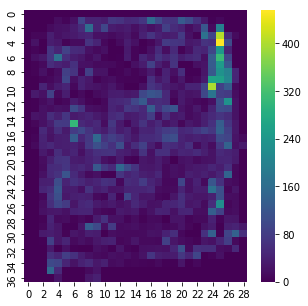

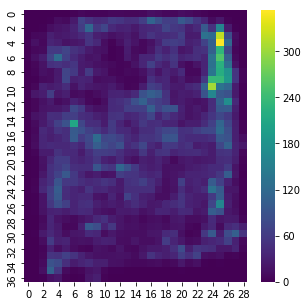

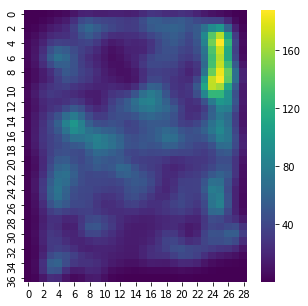

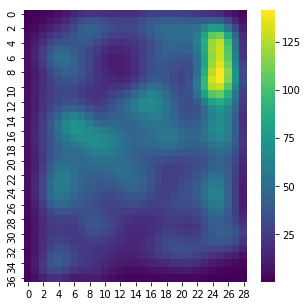

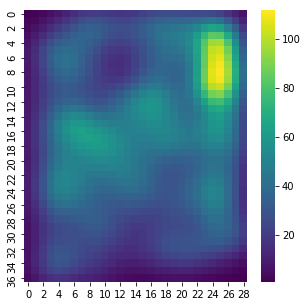

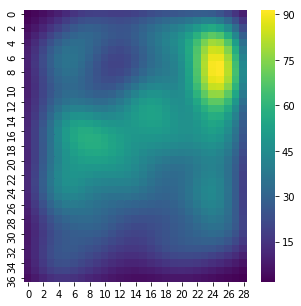

In [125]:
f,a=plt.subplots(figsize=(5,5))
sns.heatmap(position_2d,cmap='viridis',ax=a)
sigmas = [0.5,1,1.5,2,2.5]
for s in sigmas:
    f,a=plt.subplots(figsize=(5,5))
    psmooth = ndimage.filters.gaussian_filter(position_2d,s,mode='constant')
    sns.heatmap(psmooth,cmap='viridis')

array([ 63.14516129,  68.14516129,  73.14516129,  78.14516129,
        83.14516129,  88.14516129,  93.14516129,  98.14516129,
       103.14516129, 108.14516129, 113.14516129, 118.14516129,
       123.14516129, 128.14516129, 133.14516129, 138.14516129,
       143.14516129, 148.14516129, 153.14516129, 158.14516129,
       163.14516129, 168.14516129, 173.14516129, 178.14516129,
       183.14516129, 188.14516129, 193.14516129, 198.14516129,
       203.14516129, 208.14516129, 213.14516129, 218.14516129,
       223.14516129, 228.14516129, 233.14516129, 238.14516129,
       243.14516129, 248.14516129])

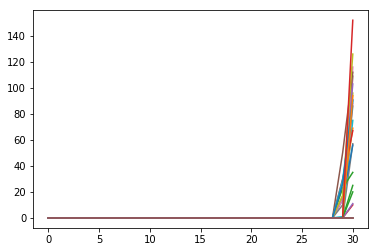

In [91]:
plt.plot(position_2d)

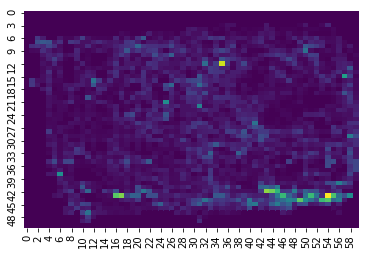

In [70]:
sns.heatmap(position_2d,cmap='viridis',
                   cbar=False,robust=False)

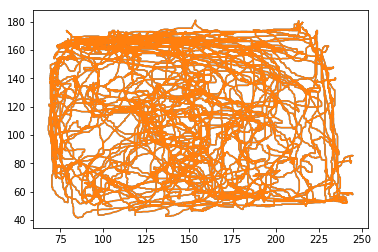

In [41]:
x2,y2=f_xy(t)
plt.plot(-y2+245,x2+110)
plt.plot(x,y)

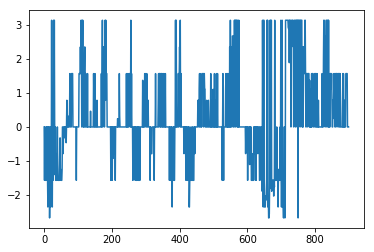

In [49]:
dx=np.diff(x2)
dy=np.diff(y2)
th=atan2v(dy,dx)
plt.plot(th[np.arange(100,1000)])

(array([1.4000e+01, 6.7000e+01, 2.0000e+00, 1.2700e+02, 6.0000e+00,
        2.0200e+02, 4.0000e+00, 3.4000e+01, 1.4000e+01, 1.0000e+00,
        8.1000e+02, 0.0000e+00, 4.0000e+00, 4.7000e+01, 9.0000e+00,
        2.1700e+02, 2.0000e+00, 1.4000e+01, 9.3000e+01, 4.1000e+01,
        5.7000e+01, 1.6000e+01, 1.0000e+00, 3.7250e+03, 1.0000e+00,
        2.4000e+01, 6.0000e+01, 5.2000e+01, 1.0600e+02, 1.3000e+01,
        7.0000e+00, 1.8300e+02, 1.2000e+01, 6.5000e+01, 8.0000e+00,
        0.0000e+00, 7.1200e+02, 2.0000e+00, 2.2000e+01, 4.5000e+01,
        1.1000e+01, 1.5800e+02, 7.0000e+00, 6.9000e+01, 2.0000e+00,
        5.9000e+01, 1.5000e+01, 0.0000e+00, 1.8644e+04, 0.0000e+00,
        1.0000e+00, 1.8000e+01, 4.2000e+01, 2.0000e+00, 1.0900e+02,
        1.2000e+01, 2.1600e+02, 4.0000e+00, 3.8000e+01, 8.0000e+00,
        2.0000e+00, 8.6200e+02, 0.0000e+00, 9.0000e+00, 4.7000e+01,
        1.1000e+01, 2.4800e+02, 3.0000e+00, 1.0000e+01, 1.2100e+02,
        7.6000e+01, 4.2000e+01, 2.6000e+01, 1.00

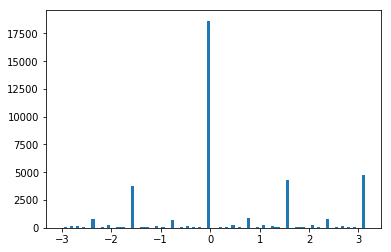

In [47]:
plt.hist(th,100)

In [43]:
def atan2v(dy,dx):
    N = len(dy)
    out = np.zeros(N)
    for i in np.arange(N):
        out[i] = np.math.atan2(dy[i],dx[i])
    return out

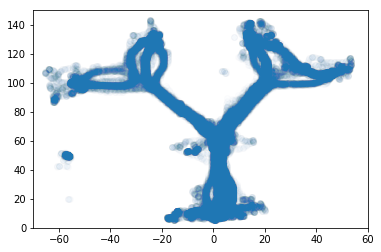

In [66]:

f,a = plt.subplots()
a.scatter(p.data.T[0],p.data.T[1],alpha=0.01)



In [68]:
yedges

array([ -3,   0,   3,   6,   9,  12,  15,  18,  21,  24,  27,  30,  33,
        36,  39,  42,  45,  48,  51,  54,  57,  60,  63,  66,  69,  72,
        75,  78,  81,  84,  87,  90,  93,  96,  99, 102, 105, 108, 111,
       114, 117, 120, 123, 126, 129, 132, 135, 138, 141, 144, 147, 150])

Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Vega10, Vega10_r, Vega20, Vega20_r, Vega20b, Vega20b_r, Vega20c, Vega20c_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, jet, jet_r, magma, magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spectral, spectral_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, viridis, viridis_r, vlag, vlag_r, winter, winter_r